## Load Pickle Data

In [1]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Import necessary items from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Activation, Dropout, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D, BatchNormalization
# from tensorflow.keras.layers.BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [2]:
# Load training images
path = '/scratch1/pswaroo/data/curated_data/'

In [3]:
train_images = np.load(path+'images/foggy.npy')

In [4]:
train_images.shape

(130, 720, 1280, 3)

(130, 432, 768, 3)


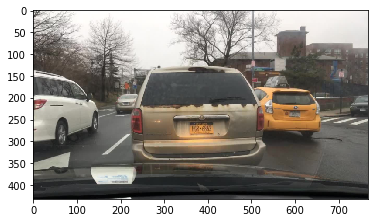

In [5]:
i = 0

scale_percent = 60 # percent of original size
width = int(train_images[0].shape[1] * scale_percent / 100)
height = int(train_images[0].shape[0] * scale_percent / 100)
dim = (width, height)
# print(height)
X_train = []
for image in train_images:
#     plt.imshow(image)
    X_train.append(cv2.resize(image, dim, interpolation = cv2.INTER_AREA))
# resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
train_images = np.asarray(X_train)
print(train_images.shape)
plt.imshow(train_images[0])

In [27]:
train_labels = np.load(path+'labels/foggy_labels.npy')
y_train = []
for label in train_labels:
    y_train.append(cv2.resize(image, dim, interpolation = cv2.INTER_AREA))

train_labels = np.asarray(y_train)
print(train_labels.shape)

(130, 432, 768, 3)


In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [56]:
## filter_size = (5, 5)
# activation_type = 'relu'
pool_size = (2,2)

model = tf.keras.Sequential()
# model = Sequential()
# Normalizes incoming inputs. First layer needs the input shape to work
# model.add(BatchNormalization(input_shape=(720,1280,3)))
# Below layers were re-named for easier reading of model summary; this not necessary
# Conv Layer 1
model.add(layers.Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1', input_shape=(432,768,3)))

# Conv Layer 2
model.add(layers.Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'))

# Pooling 1
model.add(layers.MaxPooling2D(pool_size=pool_size))

# Conv Layer 7
model.add(layers.Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv7'))
model.add(layers.Dropout(0.2))

# Pooling 3
model.add(layers.MaxPooling2D(pool_size=pool_size))

# Upsample 1
model.add(layers.UpSampling2D(size=pool_size))


# Deconv 5
model.add(layers.Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv5'))
model.add(layers.Dropout(0.2))

# Upsample 3
model.add(layers.UpSampling2D(size=pool_size))

# Deconv 6
model.add(layers.Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv6'))

# Final layer - only including one channel so 1 filter
model.add(layers.Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Final'))




In [57]:
# tf.keras.utils.plot_model(
#     model)
# model.summary()

In [58]:
batch_size = 16
epochs = 50
# datagen = ImageDataGenerator(channel_shift_range=0.2)
X_train = train_images
y_train = train_labels
# datagen.fit(X_train)

model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=batch_size, steps_per_epoch=len(train_images)/batch_size,epochs=epochs, verbose=2)

# # Freeze layers since training is done
# model.trainable = False
# model.compile(optimizer='Adam', loss='mean_squared_error')

Epoch 1/50
8/8 - 2s - loss: 3097.0195 - accuracy: 1.8857e-06
Epoch 2/50
8/8 - 1s - loss: 2629.3782 - accuracy: 1.9707e-06
Epoch 3/50
8/8 - 1s - loss: 2481.2957 - accuracy: 2.0017e-06
Epoch 4/50
8/8 - 1s - loss: 2424.7107 - accuracy: 2.0017e-06
Epoch 5/50
8/8 - 1s - loss: 2381.7900 - accuracy: 2.0094e-06
Epoch 6/50
8/8 - 1s - loss: 2374.0591 - accuracy: 2.0094e-06
Epoch 7/50
8/8 - 1s - loss: 2342.4417 - accuracy: 2.0094e-06
Epoch 8/50
8/8 - 1s - loss: 2322.2668 - accuracy: 2.0094e-06
Epoch 9/50
8/8 - 1s - loss: 2304.7947 - accuracy: 2.0094e-06
Epoch 10/50
8/8 - 1s - loss: 2328.3455 - accuracy: 2.0094e-06
Epoch 11/50
8/8 - 1s - loss: 2274.7734 - accuracy: 2.0094e-06
Epoch 12/50
8/8 - 1s - loss: 2283.8645 - accuracy: 2.0094e-06
Epoch 13/50
8/8 - 1s - loss: 2271.2839 - accuracy: 2.0094e-06
Epoch 14/50
8/8 - 1s - loss: 2235.5874 - accuracy: 2.0094e-06
Epoch 15/50
8/8 - 1s - loss: 2269.6477 - accuracy: 2.0094e-06
Epoch 16/50
8/8 - 1s - loss: 2245.3967 - accuracy: 2.0094e-06
Epoch 17/50
8/8 -